In [5]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [6]:
# Initialize random number generator
np.random.seed(123)

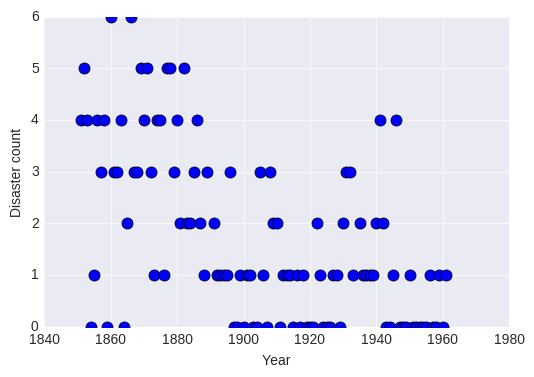

In [7]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");
plt.show()

In [17]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 10)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

In [18]:
with disaster_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to disasters_missing
100%|██████████| 10500/10500 [01:03<00:00, 167.40it/s]


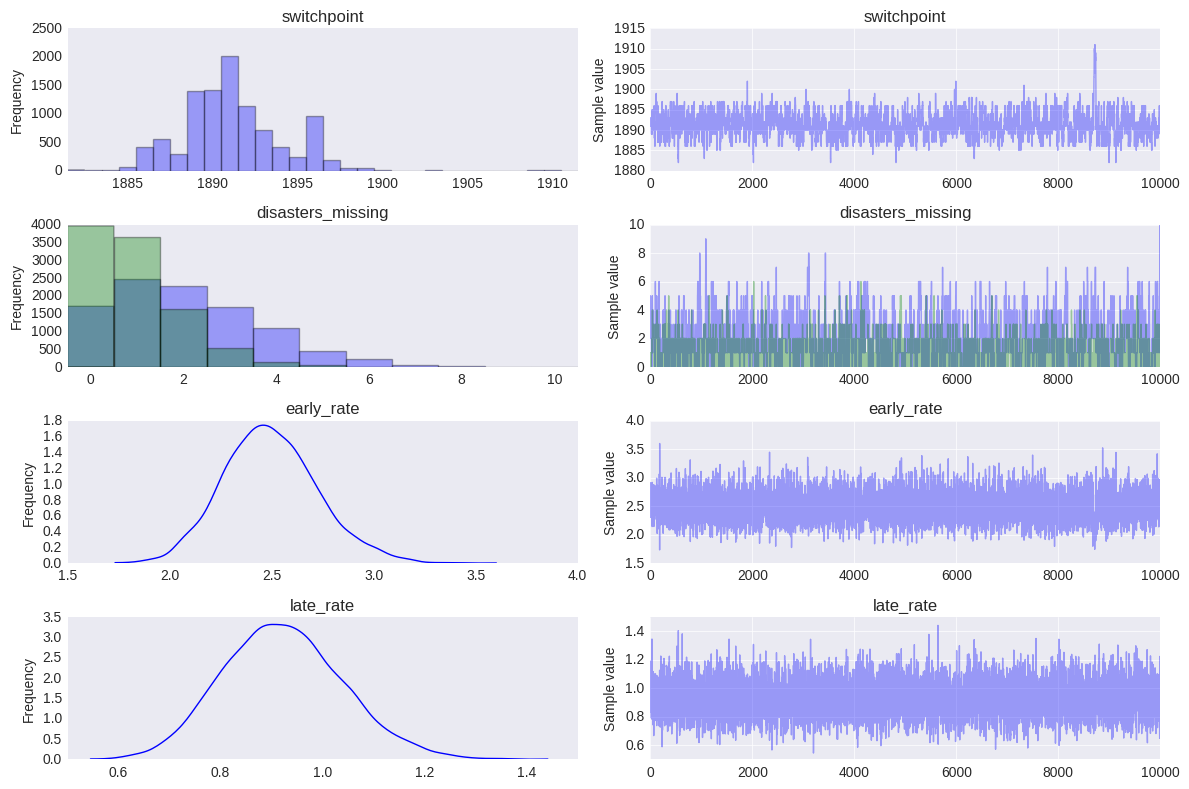

In [19]:
pm.traceplot(trace)
plt.show()

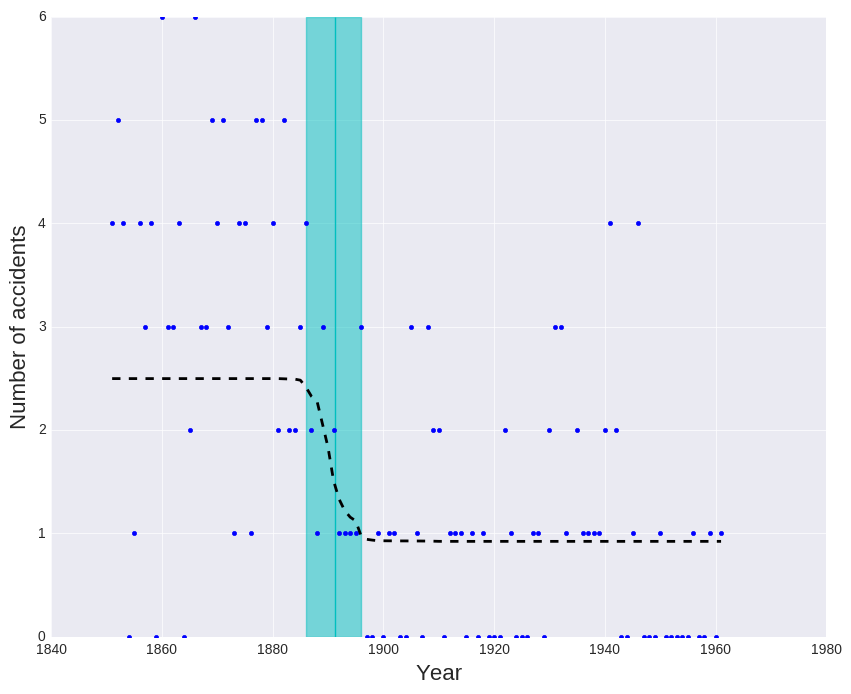

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1')
plt.plot(years, average_disasters,  'k--', lw=2)
plt.show()

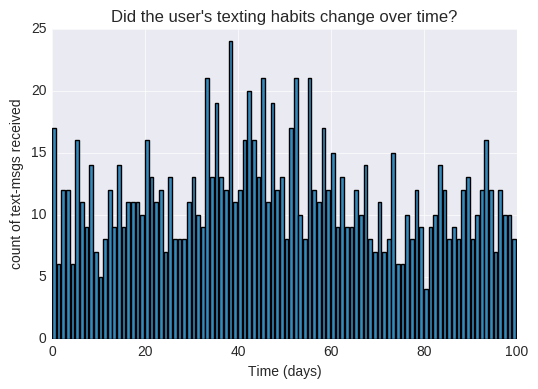

In [16]:
count_data = np.loadtxt("data/text_data.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)
plt.show()

In [23]:
import theano.tensor as tt
from theano.compile.ops import as_op

In [26]:
alpha = 1.0 / count_data.mean()
idx = np.arange(n_count_data)

@as_op(itypes=[tt.lscalar, tt.lscalar, tt.dscalar, tt.dscalar, tt.dscalar],otypes=[tt.dvector])
def rateFunc(switchpoint_1, switchpoint_2, early_mean, mid_mean, late_mean):
    ''' Concatenate Poisson means '''
    out = np.zeros(np.shape(count_data))
    out[:switchpoint_1] = early_mean
    out[switchpoint_1:switchpoint_2] = mid_mean
    out[switchpoint_2:] = late_mean
    return out

with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)
    
    tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data - 1, testval=33)
    tau_2 = pm.DiscreteUniform("tau_2", lower=0, upper=n_count_data - 1, testval=66)
    
    rate = rateFunc(tau_1, tau_2, lambda_1, lambda_2, lambda_3)
    
    observation = pm.Poisson("obs", rate, observed=count_data)

In [29]:
with model:
    # Use slice sampler for means
    step1 = pm.Slice([lambda_1, lambda_2, lambda_3])
    # Use Metropolis for switchpoint, since it accomodates discrete variables
    step2 = pm.Metropolis([tau_1, tau_2])
    trace = pm.sample(2000, tune=500, step=[step1, step2], njobs=1)

100%|██████████| 2500/2500 [00:06<00:00, 405.20it/s]   | 1/2500 [00:00<04:16,  9.73it/s]


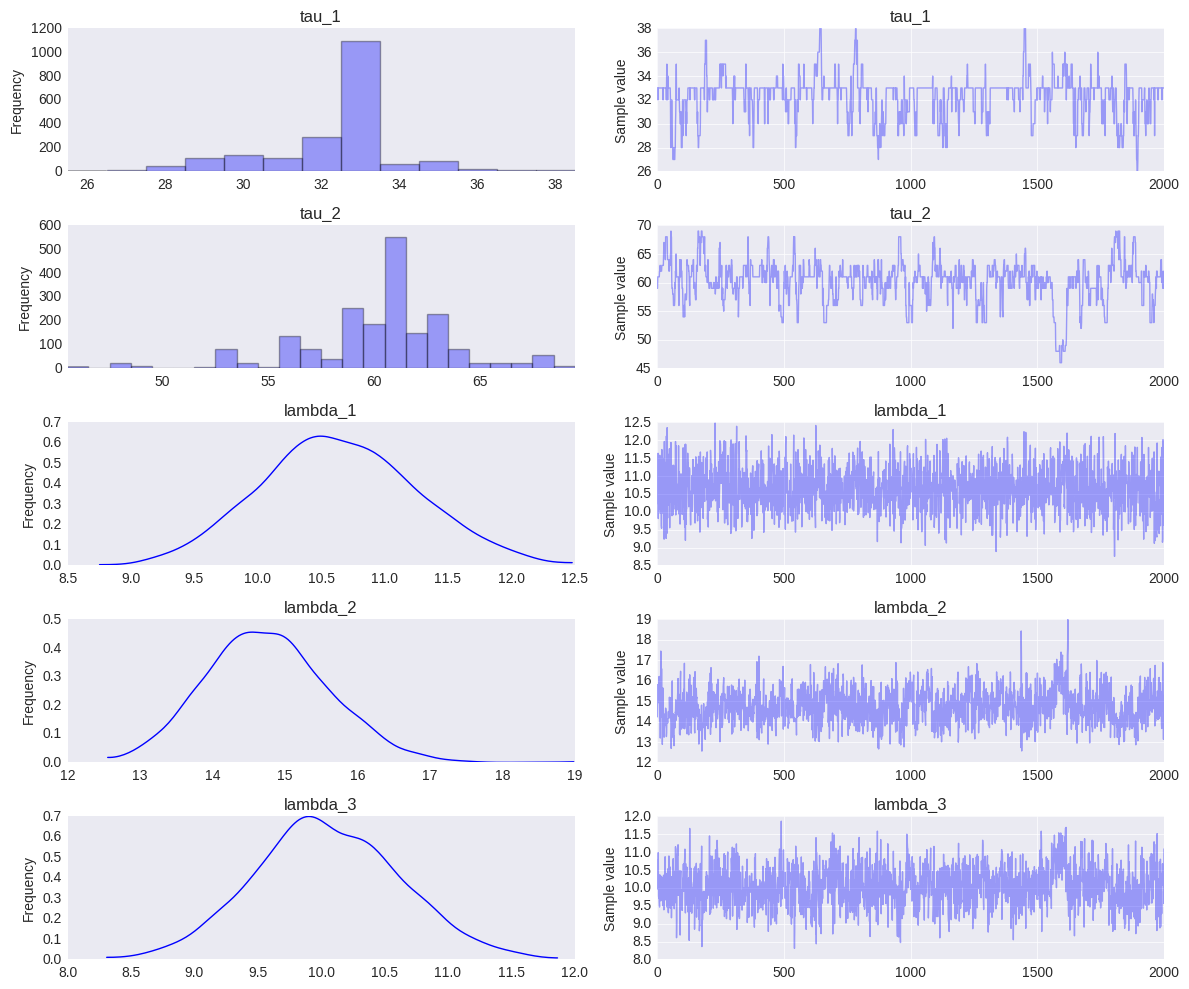

In [30]:
pm.traceplot(trace)
plt.show()

In [31]:
pm.summary(trace).round(2)


tau_1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  32.367           1.692            0.121            [28.000, 35.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  28.000         32.000         33.000         33.000         35.000


tau_2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  60.228           3.618            0.295            [53.000, 68.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  53.000         59.000         61.000         62.000         68.000


lambda_1:

  Mean             SD               MC Error         95% HPD interval
  ----------------

AttributeError: 'NoneType' object has no attribute 'round'